In [1]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")
import matplotlib.gridspec as gridspec
import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F

from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


In [5]:
sp1 = dict(tau_min=.2, tau_max=25.0, buff_max=45,
           k=20, dt=.2, ntau=100, g=0.0, ttype=ttype,)


In [7]:
sith = iSITH(**sp1)
conv = nn.Conv2d(1, 1,
              kernel_size=(1, 
                           10), 
              dilation=(1, 1), bias=True).cuda()
print(sith.tau_star)

tensor([ 0.2000,  0.2100,  0.2205,  0.2315,  0.2431,  0.2552,  0.2680,  0.2814,
         0.2954,  0.3102,  0.3257,  0.3420,  0.3591,  0.3770,  0.3959,  0.4157,
         0.4364,  0.4583,  0.4812,  0.5052,  0.5305,  0.5570,  0.5848,  0.6140,
         0.6447,  0.6769,  0.7108,  0.7463,  0.7836,  0.8228,  0.8639,  0.9071,
         0.9524,  1.0000,  1.0500,  1.1025,  1.1576,  1.2154,  1.2762,  1.3399,
         1.4069,  1.4772,  1.5511,  1.6286,  1.7100,  1.7954,  1.8852,  1.9794,
         2.0783,  2.1822,  2.2913,  2.4058,  2.5260,  2.6523,  2.7848,  2.9240,
         3.0702,  3.2236,  3.3847,  3.5539,  3.7315,  3.9180,  4.1138,  4.3194,
         4.5353,  4.7620,  5.0000,  5.2499,  5.5123,  5.7878,  6.0771,  6.3808,
         6.6997,  7.0346,  7.3861,  7.7553,  8.1429,  8.5499,  8.9772,  9.4259,
         9.8970, 10.3916, 10.9110, 11.4563, 12.0289, 12.6301, 13.2614, 13.9242,
        14.6201, 15.3508, 16.1180, 16.9236, 17.7694, 18.6575, 19.5900, 20.5692,
        21.5972, 22.6766, 23.8100, 25.00

In [9]:
temp1 = ttype([1,0,0,0,0, 0,0,0,0,0, 1,0,0,0,0, 0,0,0,0,0, 1,0,0,0,0]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
temp2a = temp1.unsqueeze(-1).repeat(1,1,1,1,2).reshape(1,1,1,50)
temp2b = temp1.reshape(1,1,5,5).repeat(1,1,1,2).reshape(1,1,1,50)

In [10]:
so1 = sith(temp1)
so2a = sith(temp2a)
so2b = sith(temp2b)
print(so1.shape, so2a.shape, so2b.shape)

torch.Size([1, 100, 1, 25]) torch.Size([1, 100, 1, 50]) torch.Size([1, 100, 1, 50])


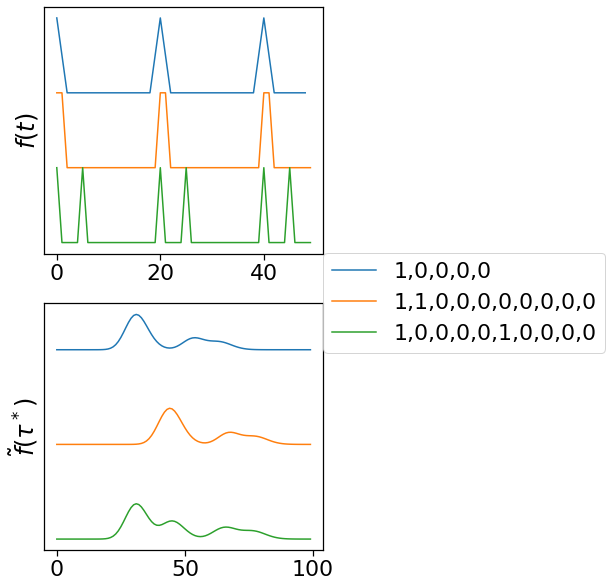

In [11]:
window_size = 20
with sn.plotting_context("notebook", font_scale=2):
    fig = plt.figure(figsize=(5,10))
    spec = gridspec.GridSpec(nrows=2, ncols=1,
                             wspace=.15,hspace=.2, figure=fig)
    ax = fig.add_subplot(spec[0])
    plt.plot(range(0,50,2), temp1[0,0,0].cpu()+1)
    plt.plot(temp2a[0,0,0].cpu())
    plt.plot(temp2b[0,0,0].cpu()-1)
    ax.set_ylabel(r"$f(t)$")
    ax.set_yticks([])

    ax = fig.add_subplot(spec[1])
    plt.plot(so1[0,:,0,-1].detach().cpu()+1)
    plt.plot(so2a[0,:,0,-1].detach().cpu())
    plt.plot(so2b[0,:,0,-1].detach().cpu()-1)
    ax.set_ylabel(r"$\tilde{f}(\tau^*)$")
    ax.set_yticks([])
    leg = plt.legend(["1,0,0,0,0",
                      "1,1,0,0,0,0,0,0,0,0",
                      "1,0,0,0,0,1,0,0,0,0"],
                    loc=(1,.8))


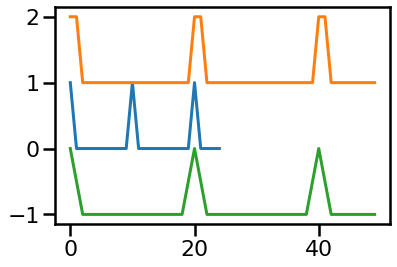

In [12]:
temp1 = ttype([1,0,0,0,0, 0,0,0,0,0, 1,0,0,0,0, 0,0,0,0,0, 1,0,0,0,0]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
temp2b = ttype([1,.5,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,.5, 
               1,.5,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,.5, 
               1,.5,0,0,0,0,0,0,0,0, ]).unsqueeze(0).unsqueeze(0).unsqueeze(0)

temp2a = temp1.unsqueeze(-1).repeat(1,1,1,1,2).reshape(1,1,1,50)
plt.plot(temp1[0,0,0].cpu())
plt.plot(temp2a[0,0,0].cpu()+1)
plt.plot(temp2b[0,0,0].cpu()-1)

In [14]:
so1 = sith(temp1)
tso1 = so1.transpose(3,1)
cso1 = conv(tso1.reshape(-1, 1, tso1.shape[2], tso1.shape[3]))

so2a = sith(temp2a)
tso2a = so2a.transpose(3,1)
cso2a = conv(tso2a.reshape(-1, 1, tso2a.shape[2], tso2a.shape[3]))


print(so1.shape, cso1.shape, so2a.shape, cso2a.shape)

torch.Size([1, 100, 1, 25]) torch.Size([25, 1, 1, 91]) torch.Size([1, 100, 1, 50]) torch.Size([50, 1, 1, 91])


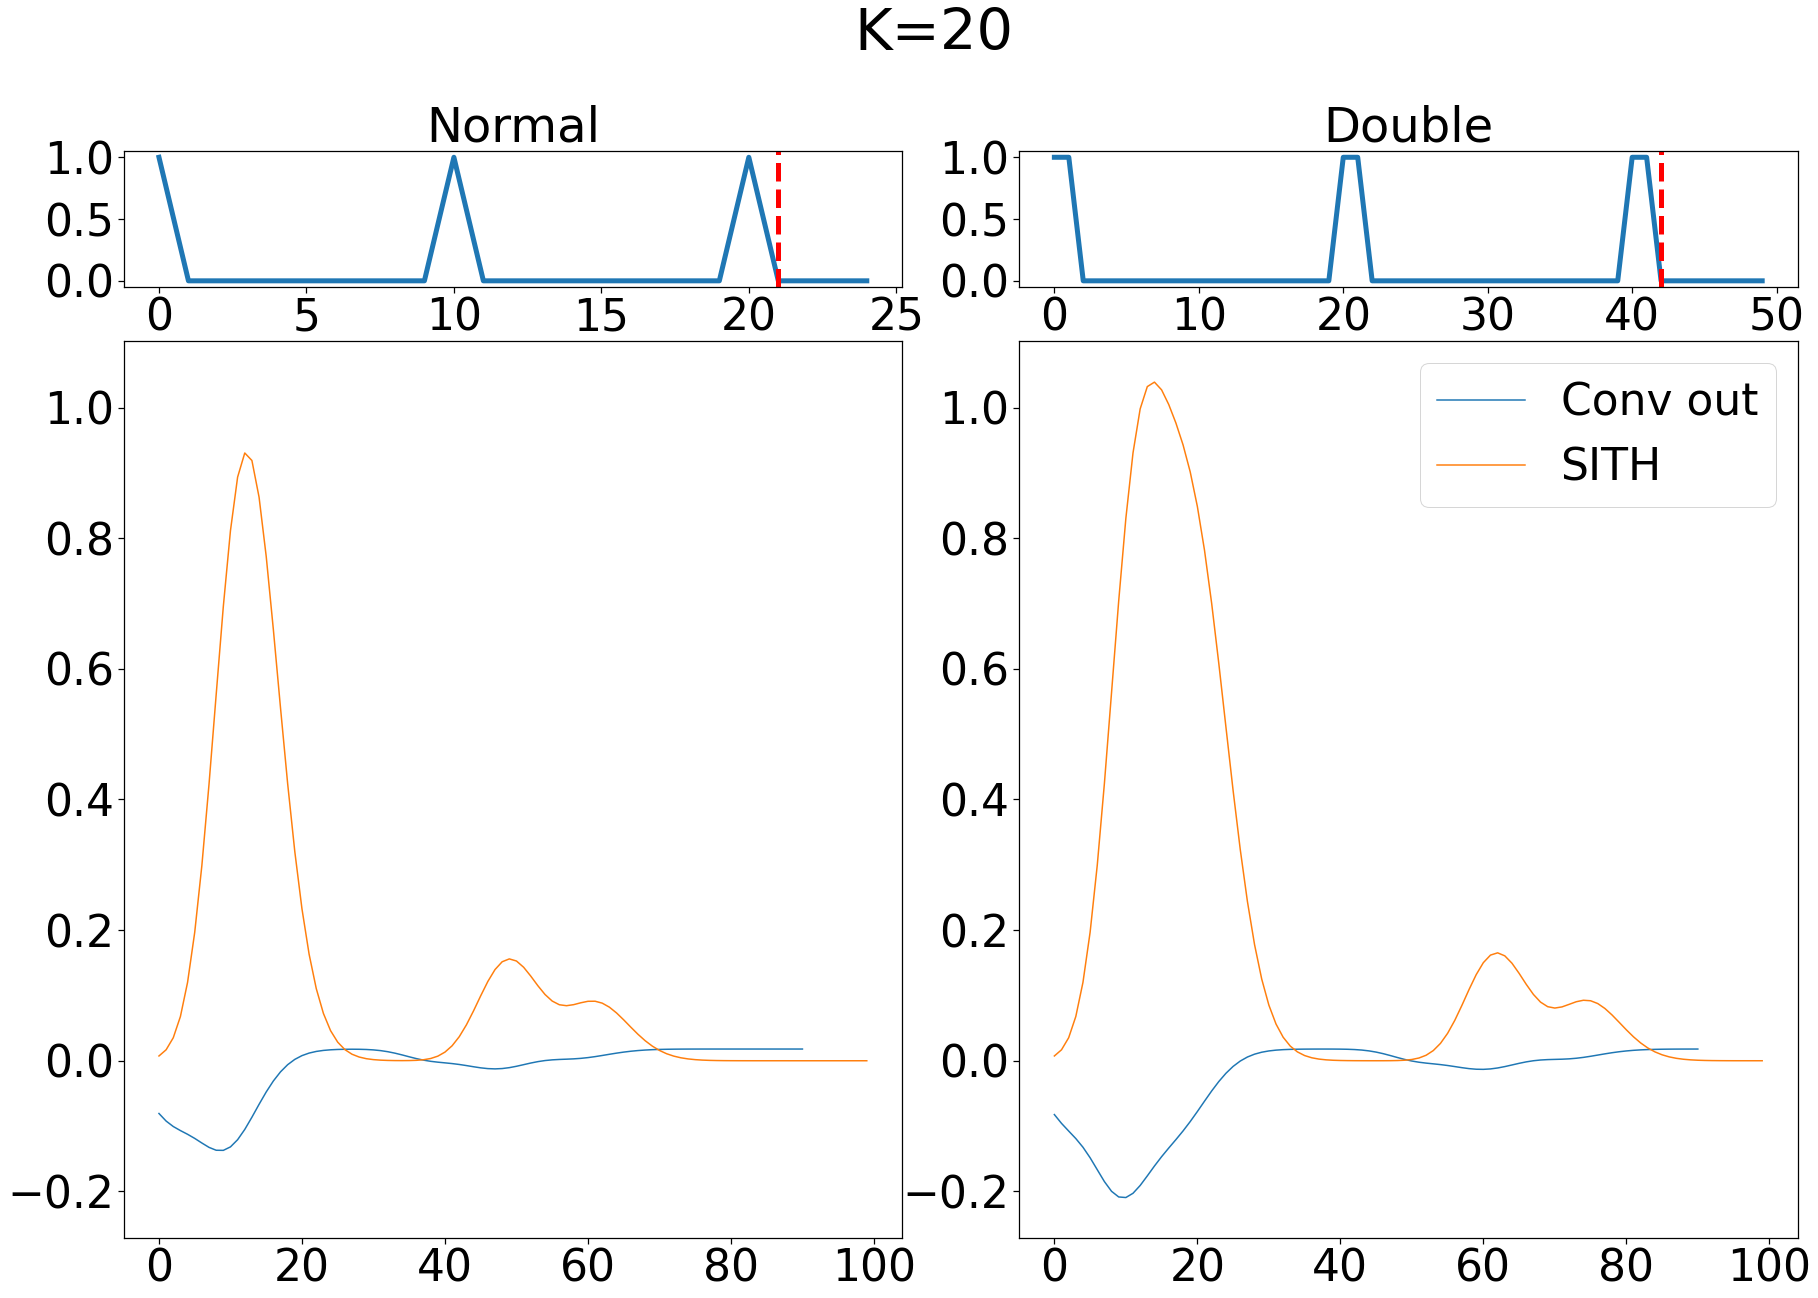

In [15]:
window_size = 20

i = 21
with sn.plotting_context("notebook", font_scale=4):
    fig = plt.figure(figsize=(30,20))
    plt.suptitle('K=20')
    spec = gridspec.GridSpec(nrows=6, ncols=2,
                             wspace=.15,hspace=.4, figure=fig)
    ax = fig.add_subplot(spec[0,0])
    ax.plot(temp1[0,0,0].cpu(), lw=5)
    ax.axvline(i, lw=5, color='red', linestyle='--')
    ax.set_title('Normal')
    
    ax = fig.add_subplot(spec[0,1], sharey=ax)
    ax.plot(temp2a[0,0,0].cpu(), lw=5)
    ax.axvline(2*i, lw=5, color='red', linestyle='--')
    ax.set_title('Double')
    
    
    ax = fig.add_subplot(spec[1:,0])
    ax.plot(cso1[i,0,0,:].detach().cpu().T)
    ax.plot(so1[0,:,0,i].detach().cpu())
    
    ax = fig.add_subplot(spec[1:,1], sharey=ax)
    ax.plot(cso2a[2*i, 0, 0,:].detach().cpu().T)
    ax.plot(so2a[0,:,0,2*i].detach().cpu())
    ax.legend(['Conv out', 'SITH'])


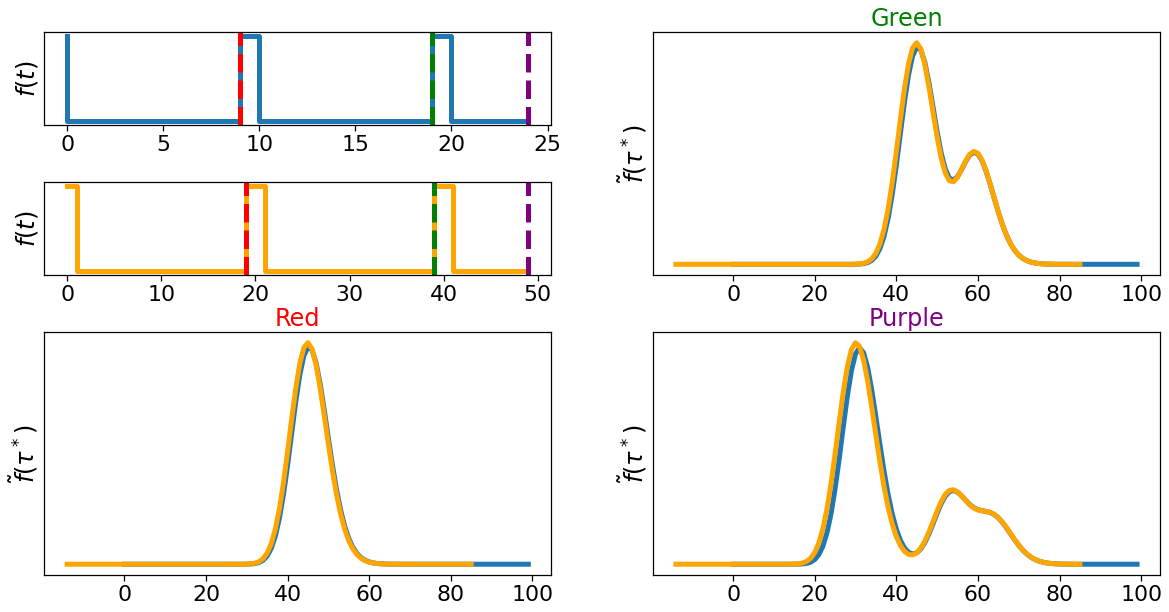

In [16]:

with sn.plotting_context("notebook", font_scale=2, rc={'lines.linewidth':5}):
    fig = plt.figure(figsize=(20,10))
    spec = gridspec.GridSpec(nrows=4, ncols=2,
                             wspace=.2,hspace=.6, figure=fig)
    ax = fig.add_subplot(spec[0, 0])
    plt.step(np.arange(temp1[0,0,0].cpu().shape[0]),
             temp1[0,0,0].cpu()+1)
    ax.axvline(9, linestyle='--', color='red')
    ax.axvline(19, linestyle='--', color='green')
    ax.axvline(24, linestyle='--', color='purple')
    ax.set_ylabel(r"$f(t)$")
    ax.set_yticks([])

    ax = fig.add_subplot(spec[1, 0])
    plt.step(np.arange(temp2a[0,0,0].cpu().shape[0]),
             temp2a[0,0,0].cpu(), color='orange')
    ax.axvline(19, linestyle='--', color='red')
    ax.axvline(39, linestyle='--', color='green')
    ax.axvline(49, linestyle='--', color='purple')
    ax.set_ylabel(r"$f(t)$")
    ax.set_yticks([])

    ax = fig.add_subplot(spec[2:, 0])
    i=10
    plt.plot(so1[0,:,0,i-1].detach().cpu())
    
    plt.plot(np.arange(0,so2a.shape[1]) - 14,
             so2a[0,:,0,i*2-1].detach().cpu(), color='orange')
    #plt.plot(so2b[0,:,0,-1].detach().cpu()21)
    ax.set_ylabel(r"$\tilde{f}(\tau^*)$")
    ax.set_yticks([])
    ax.set_title('Red', color='red')
    ax = fig.add_subplot(spec[:2, 1])
    i=20
    plt.plot(so1[0,:,0,i-1].detach().cpu())
    plt.plot(np.arange(0,so2a.shape[1]) - 14,
             so2a[0,:,0,i*2-1].detach().cpu(), color='orange')
    #plt.plot(so2b[0,:,0,-1].detach().cpu()21)
    ax.set_ylabel(r"$\tilde{f}(\tau^*)$")
    ax.set_yticks([])
    ax.set_title('Green', color='green')
    
    ax = fig.add_subplot(spec[2:, 1])
    plt.plot(so1[0,:,0,-1].detach().cpu())
    plt.plot(np.arange(0,so2a.shape[1]) - 14,
             so2a[0,:,0,-1].detach().cpu(), color='orange')
    #plt.plot(so2b[0,:,0,-1].detach().cpu()21)
    ax.set_ylabel(r"$\tilde{f}(\tau^*)$")
    ax.set_yticks([])
    ax.set_title('Purple', color='purple')
    

